# Vector space semantics

## Session 06: Testing a model

### Gerhard Jäger


May 30, 2022



In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
plt.rcParams["figure.figsize"] = (6,6)
import string
import nltk
from nltk import pos_tag
import pandas as pd
import numpy as np
from numpy import random
import scipy
import time


## SVD with corpus counts

In [2]:
nltk.download('brown')


[nltk_data] Downloading package brown to /home/gjaeger/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [3]:
brown_wordcounts = nltk.FreqDist(nltk.corpus.brown.words())


In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = np.unique(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gjaeger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def normalize_wordlist(wl):
    wl = [w.lower().strip(string.punctuation) for w in wl]
    return [w for w in wl if w != "" and not w in stop_words]


In [6]:
brown_words = normalize_wordlist(nltk.corpus.brown.words())


In [7]:
brown_wordcounts = nltk.FreqDist(brown_words)


In [8]:
brown_sents = [normalize_wordlist(s) for s in nltk.corpus.brown.sents()]
brown_sents = [s for s in brown_sents if len(s) > 0]

In [9]:
def each_contextword_1wordwindow(wordlist, targetindex):
    if targetindex > 0:
        # preceding word
        yield wordlist[targetindex - 1]
        
    if targetindex < len(wordlist)- 1:
        # succeeding word
        yield wordlist[targetindex + 1]
        

In [10]:
def each_contextword_2wordwindow(wordlist, targetindex):
    if targetindex > 0:
        # preceding word
        yield wordlist[targetindex - 1]
    if targetindex > 1:
        # preceding word
        yield wordlist[targetindex - 2]
    if targetindex < len(wordlist) - 1:
        # succeeding word
        yield wordlist[targetindex + 1]
    if targetindex < len(wordlist) - 2:
        # succeeding word
        yield wordlist[targetindex + 2]
        

In [11]:
brown_context_counts = nltk.ConditionalFreqDist()

frequency_threshold = 20

for sentence in brown_sents:
    
    for targetindex, target in enumerate(sentence):
        for contextword in each_contextword_2wordwindow(sentence, targetindex):
            if brown_wordcounts[target] >= frequency_threshold and brown_wordcounts[contextword] >= frequency_threshold:
                brown_context_counts[target][contextword] += 1   


In [12]:
frequency_threshold = 20

brown_wordlist = list(w for w in brown_wordcounts if brown_wordcounts[w] >= frequency_threshold)

In [13]:
brown_wordlist_lookup = dict((word, index) for index, word in enumerate(brown_wordlist))

### Getting POS tags similarity as benchmark

- tagging the Brown corpus

In [14]:
brown_token_pos = np.concatenate([np.array(pos_tag(s)) for s in brown_sents])
brown_token_pos

array([['fulton', 'NN'],
       ['county', 'NN'],
       ['grand', 'JJ'],
       ...,
       ['boucle', 'NN'],
       ['dress', 'NN'],
       ['stupefying', 'VBG']], dtype='<U32')

- assign each wordlist entry a probability distribution over POS tags

In [15]:
posTags = np.unique(brown_token_pos[:,1])
posTagLookup = dict((tag, index) for index, tag in enumerate(posTags))

In [16]:
## counting word-tag occurrences
t0 = time.time()
posDists = np.zeros((len(brown_wordlist), len(posTags)))
for i in range(brown_token_pos.shape[0]):
    word, tag = brown_token_pos[i,:]
    if word in brown_wordlist:
        wordIndex = brown_wordlist_lookup[word]
        tagIndex = posTagLookup[tag]
        posDists[wordIndex, tagIndex] += 1
print(time.time()-t0)

18.25319266319275


In [17]:
## normalizing each row to a probability distribution
for i in range(posDists.shape[0]):
    posDists[i,:] /= sum(posDists[i,:])

- back to building a count matrix

In [18]:
brown_count_matrix = np.zeros((len(brown_wordlist), len(brown_wordlist)))
for sentence in brown_sents:
    for targetindex, target in enumerate(sentence):
        for contextword in each_contextword_2wordwindow(sentence, targetindex):
            if brown_wordcounts[target] >= frequency_threshold and brown_wordcounts[contextword] >= frequency_threshold:
                # which cell in the matrix is this? 
                # look up both the target and the context word
                # in the ordered list of Brown words
                targetindex_matrix = brown_wordlist_lookup[target]
                contextindex_matrix = brown_wordlist_lookup[contextword]
                # and add a count of one for this cell in the matrix
                brown_count_matrix[targetindex_matrix][contextindex_matrix] += 1   


In [19]:
def cosine_sim(vec1, vec2):
    return 1 - scipy.spatial.distance.cosine(vec1, vec2)

In [20]:
uBrown, sigmaBrown_flat, vtBrown = np.linalg.svd(brown_count_matrix)

The *singular values* in `sigmaBrown_flat` tell us how much information the corresponding columns of `uBrown` / rows of `vtBrown` contribute to the information in `brown_count_matrix`.

<IPython.core.display.Javascript object>


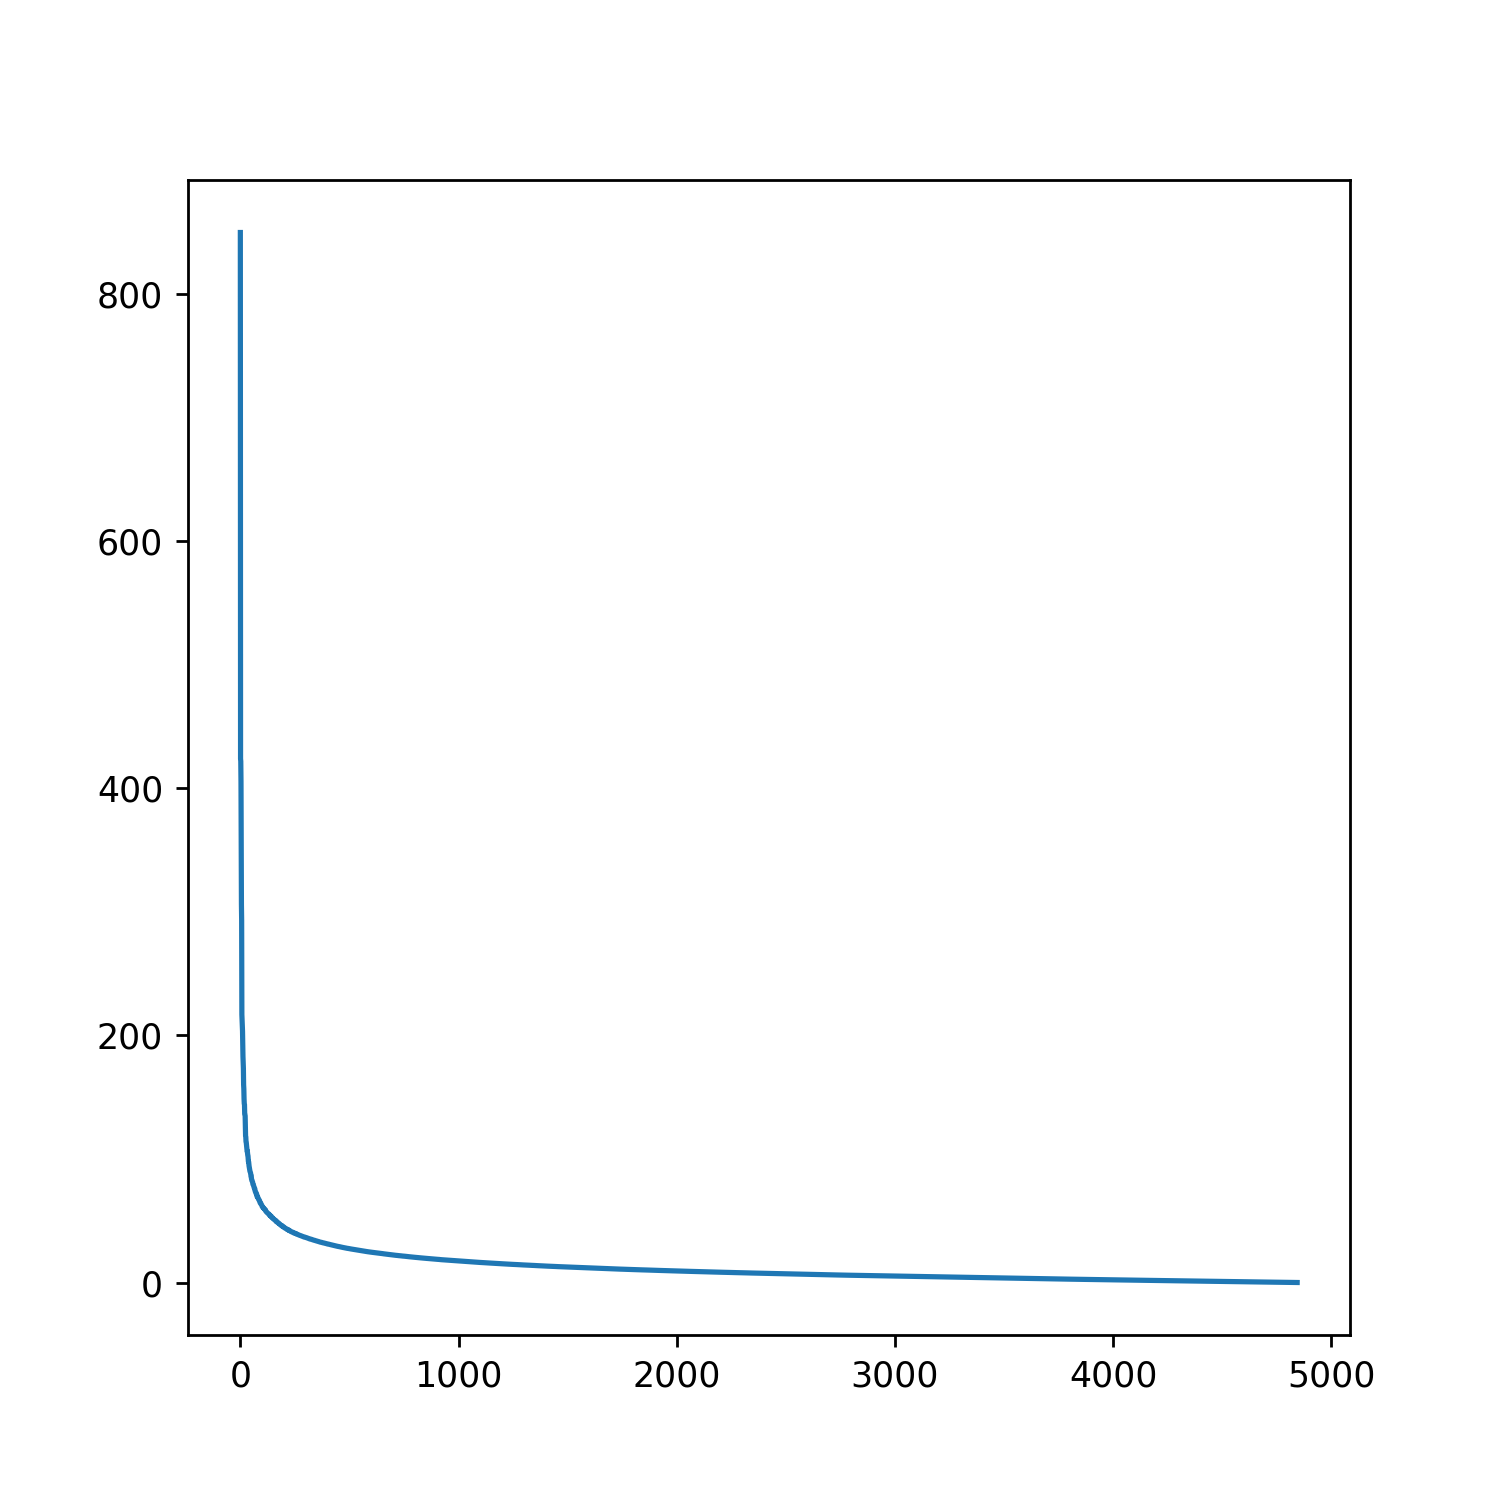

In [21]:
fig = plt.figure(figsize=(6,6))
plt.plot(sigmaBrown_flat)
plt.show()

<IPython.core.display.Javascript object>


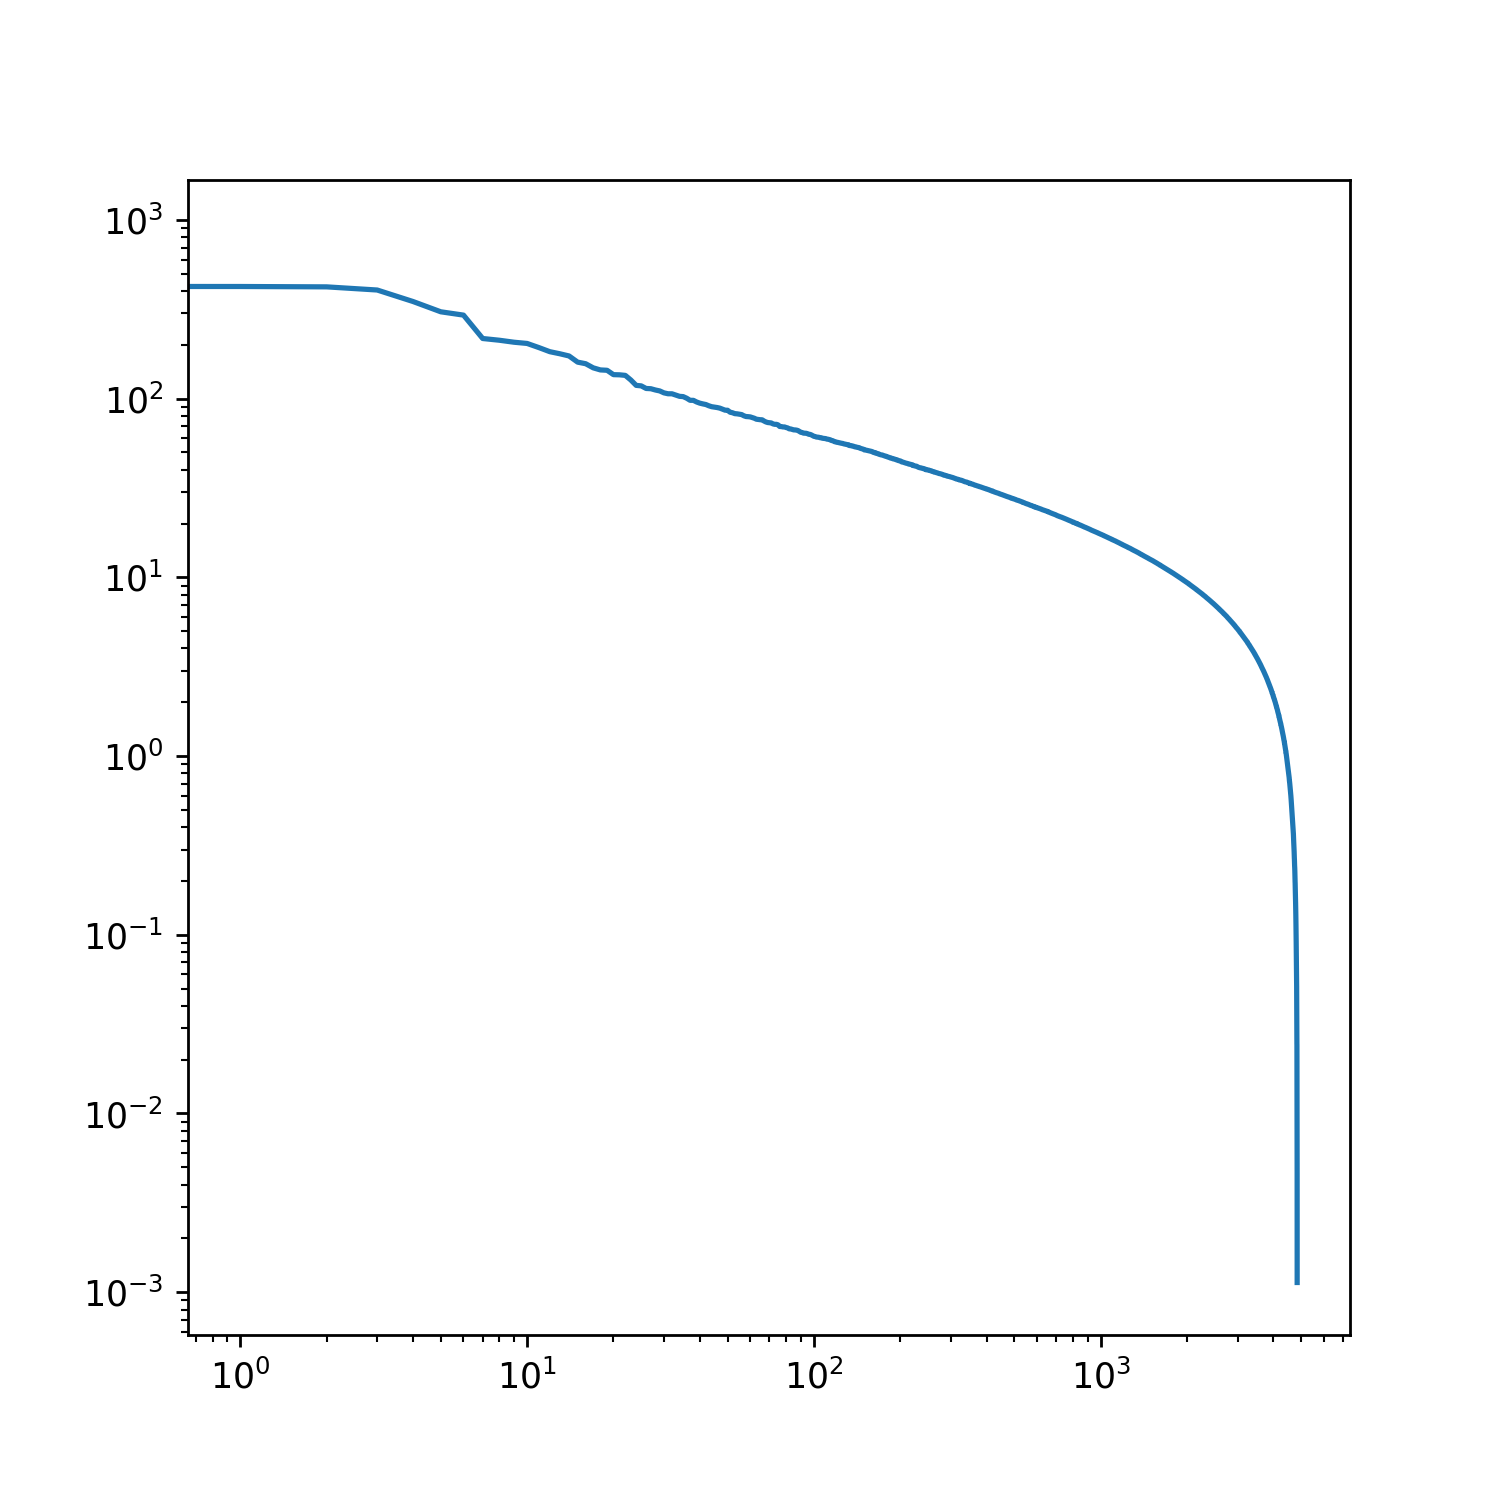

In [22]:
fig = plt.figure(figsize=(6,6))
plt.loglog(sigmaBrown_flat)
plt.show()

<IPython.core.display.Javascript object>


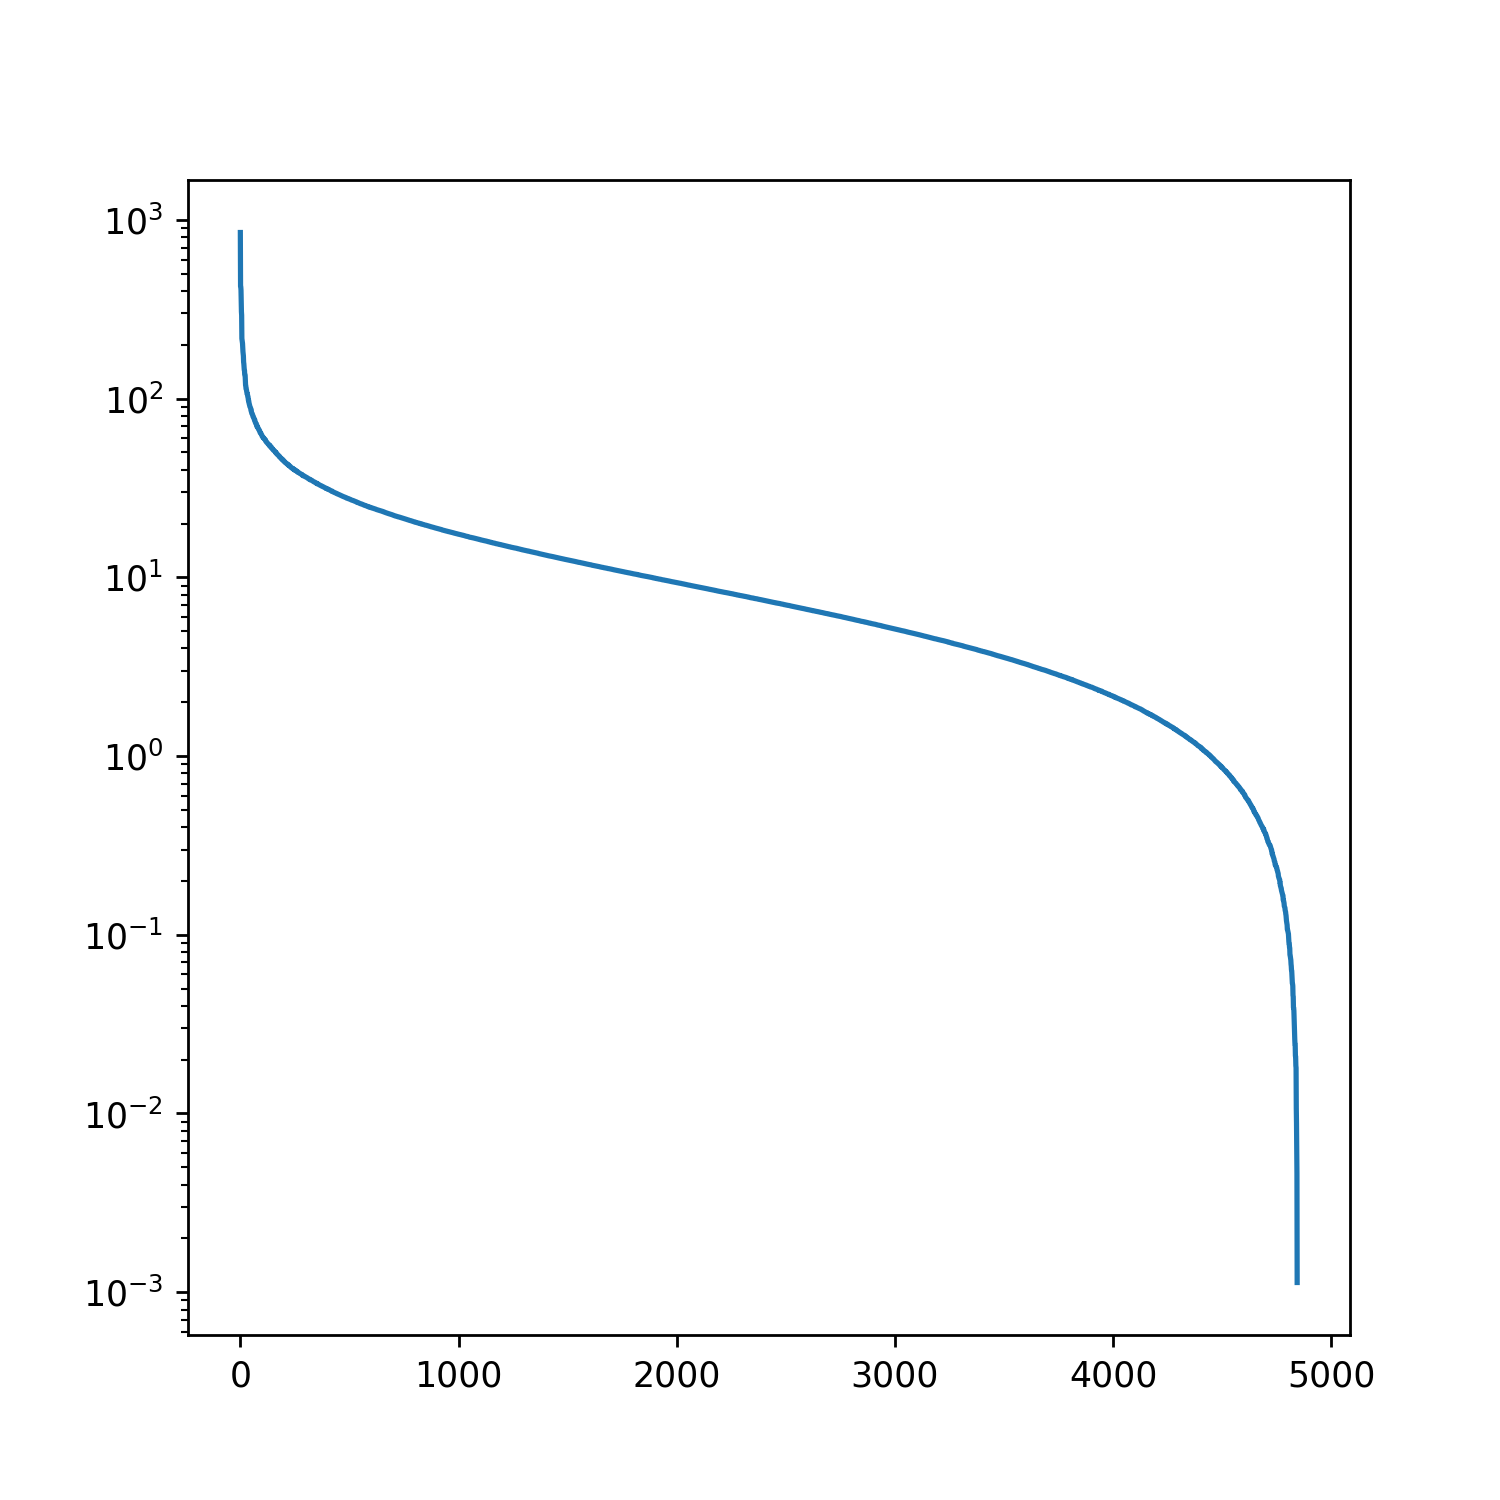

In [23]:
fig = plt.figure(figsize=(6,6))
plt.semilogy(sigmaBrown_flat)
plt.show()

### Correlation between word vectors and POS distribution

- it stands to reason that semantically similar words have a similar POS profile
- POS similarity (cosine similarity between POS distributions for simplicity's sake) should be correlated with meaning vectors
- can be used as yardstick to assess value of dimensionality reduction

In [24]:
nSamples = 10000
distComparison = np.zeros((nSamples, 2))
for i in range(nSamples):
    wi1, wi2 = random.randint(len(brown_wordlist), size=2)
    distComparison[i,0] = cosine_sim(brown_count_matrix[wi1,:], brown_count_matrix[wi2,:])
    distComparison[i,1] = posDists[wi1,:] @ posDists[wi2,:]

<IPython.core.display.Javascript object>


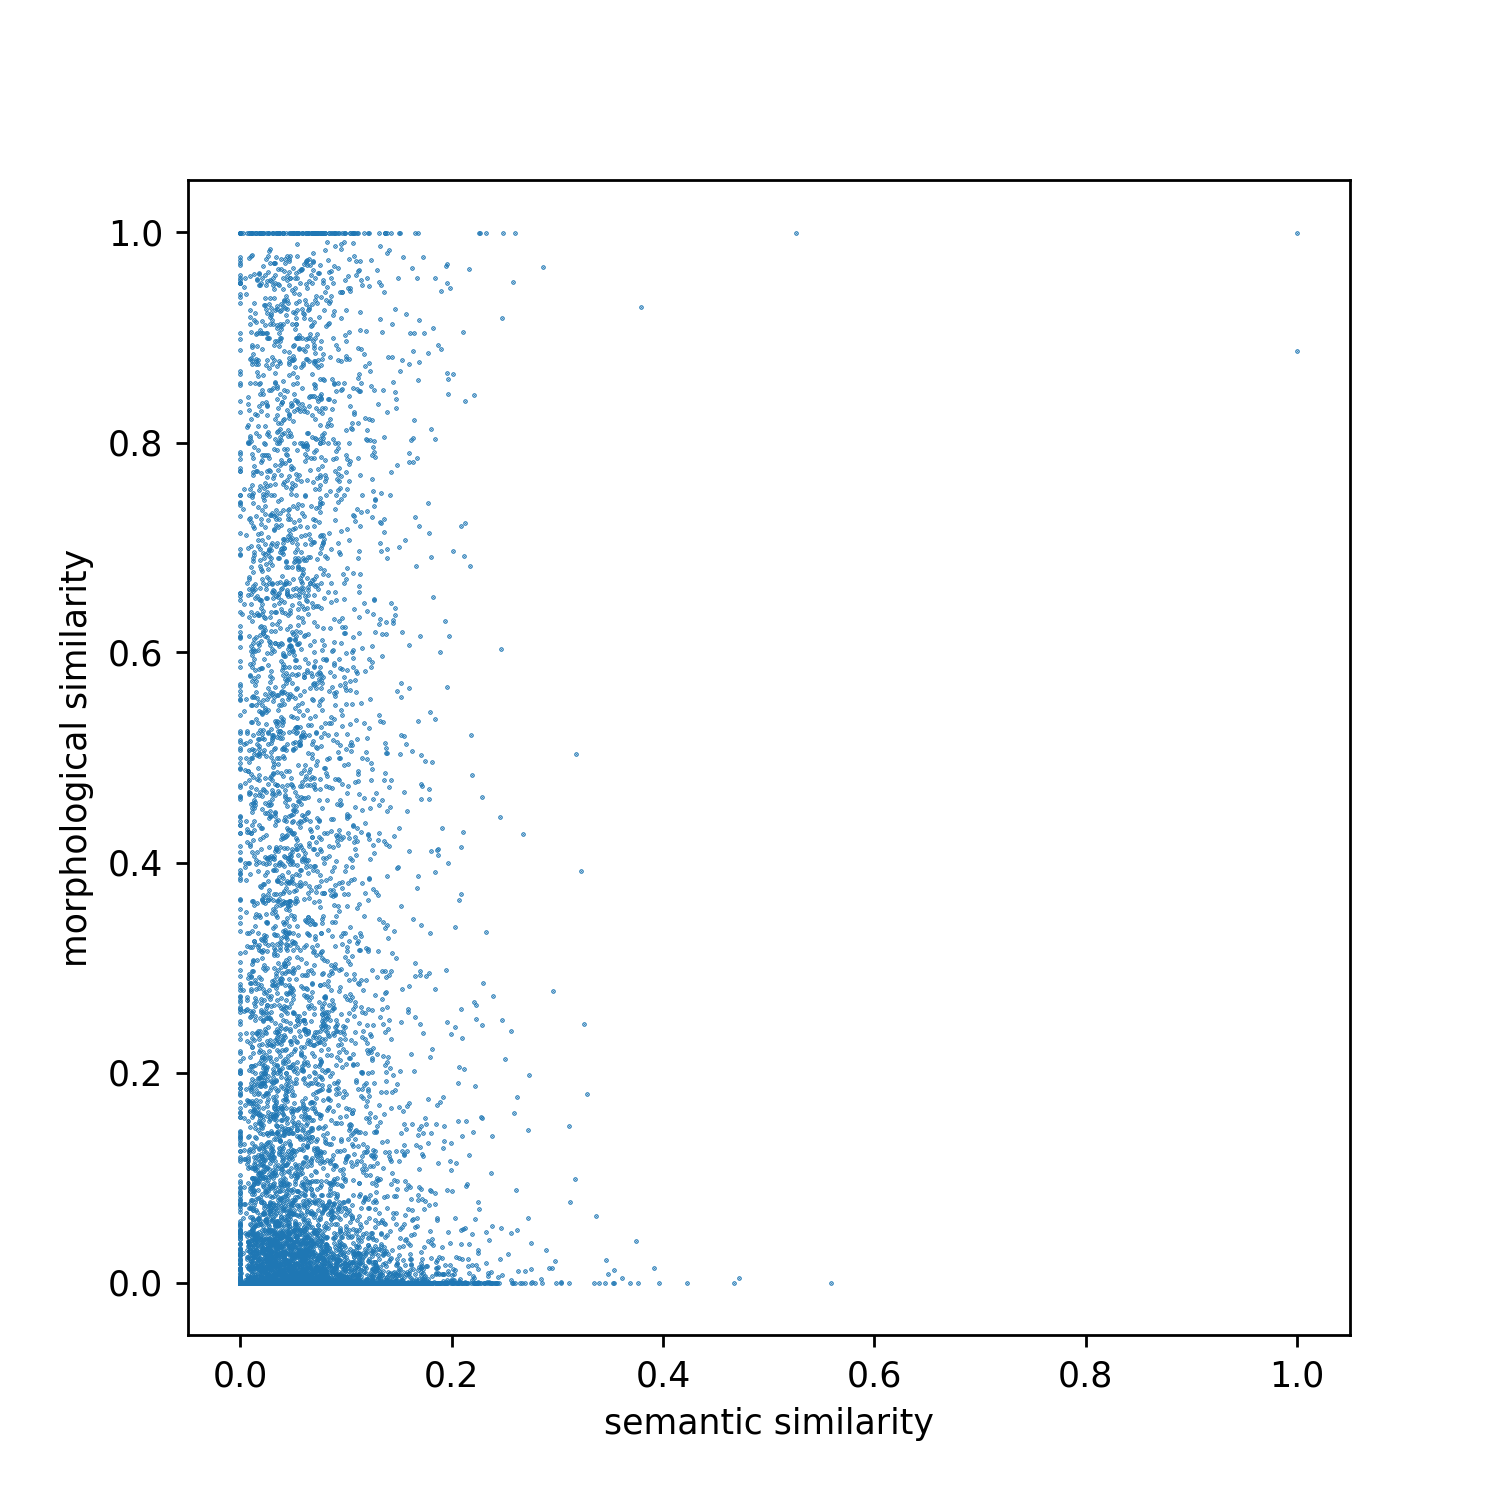

In [25]:
fig = plt.figure(figsize=(6,6))
plt.scatter(distComparison[:,0], distComparison[:,1], s=0.1)
plt.xlabel("semantic similarity")
plt.ylabel("morphological similarity")
plt.show()

In [26]:
np.corrcoef(distComparison.T)[0,1]

-0.02258896077317226

In [27]:
scipy.stats.spearmanr(distComparison)

SpearmanrResult(correlation=-0.023187355921372135, pvalue=0.02040819114930275)

In [28]:
nDimension = 20


In [30]:
sigmaBrown_reduced = np.zeros(sigmaBrown_flat.shape)
sigmaBrown_reduced[:nDimension] = sigmaBrown_flat[:nDimension]

In [31]:
brown_count_reduced = uBrown * sigmaBrown_reduced @ vtBrown

In [32]:
nSamples = 10000
distComparison = np.zeros((nSamples, 2))
for i in range(nSamples):
    wi1, wi2 = random.randint(len(brown_wordlist), size=2)
    distComparison[i,0] = cosine_sim(brown_count_reduced[wi1,:], brown_count_reduced[wi2,:])
    distComparison[i,1] = posDists[wi1,:] @ posDists[wi2,:]

<IPython.core.display.Javascript object>


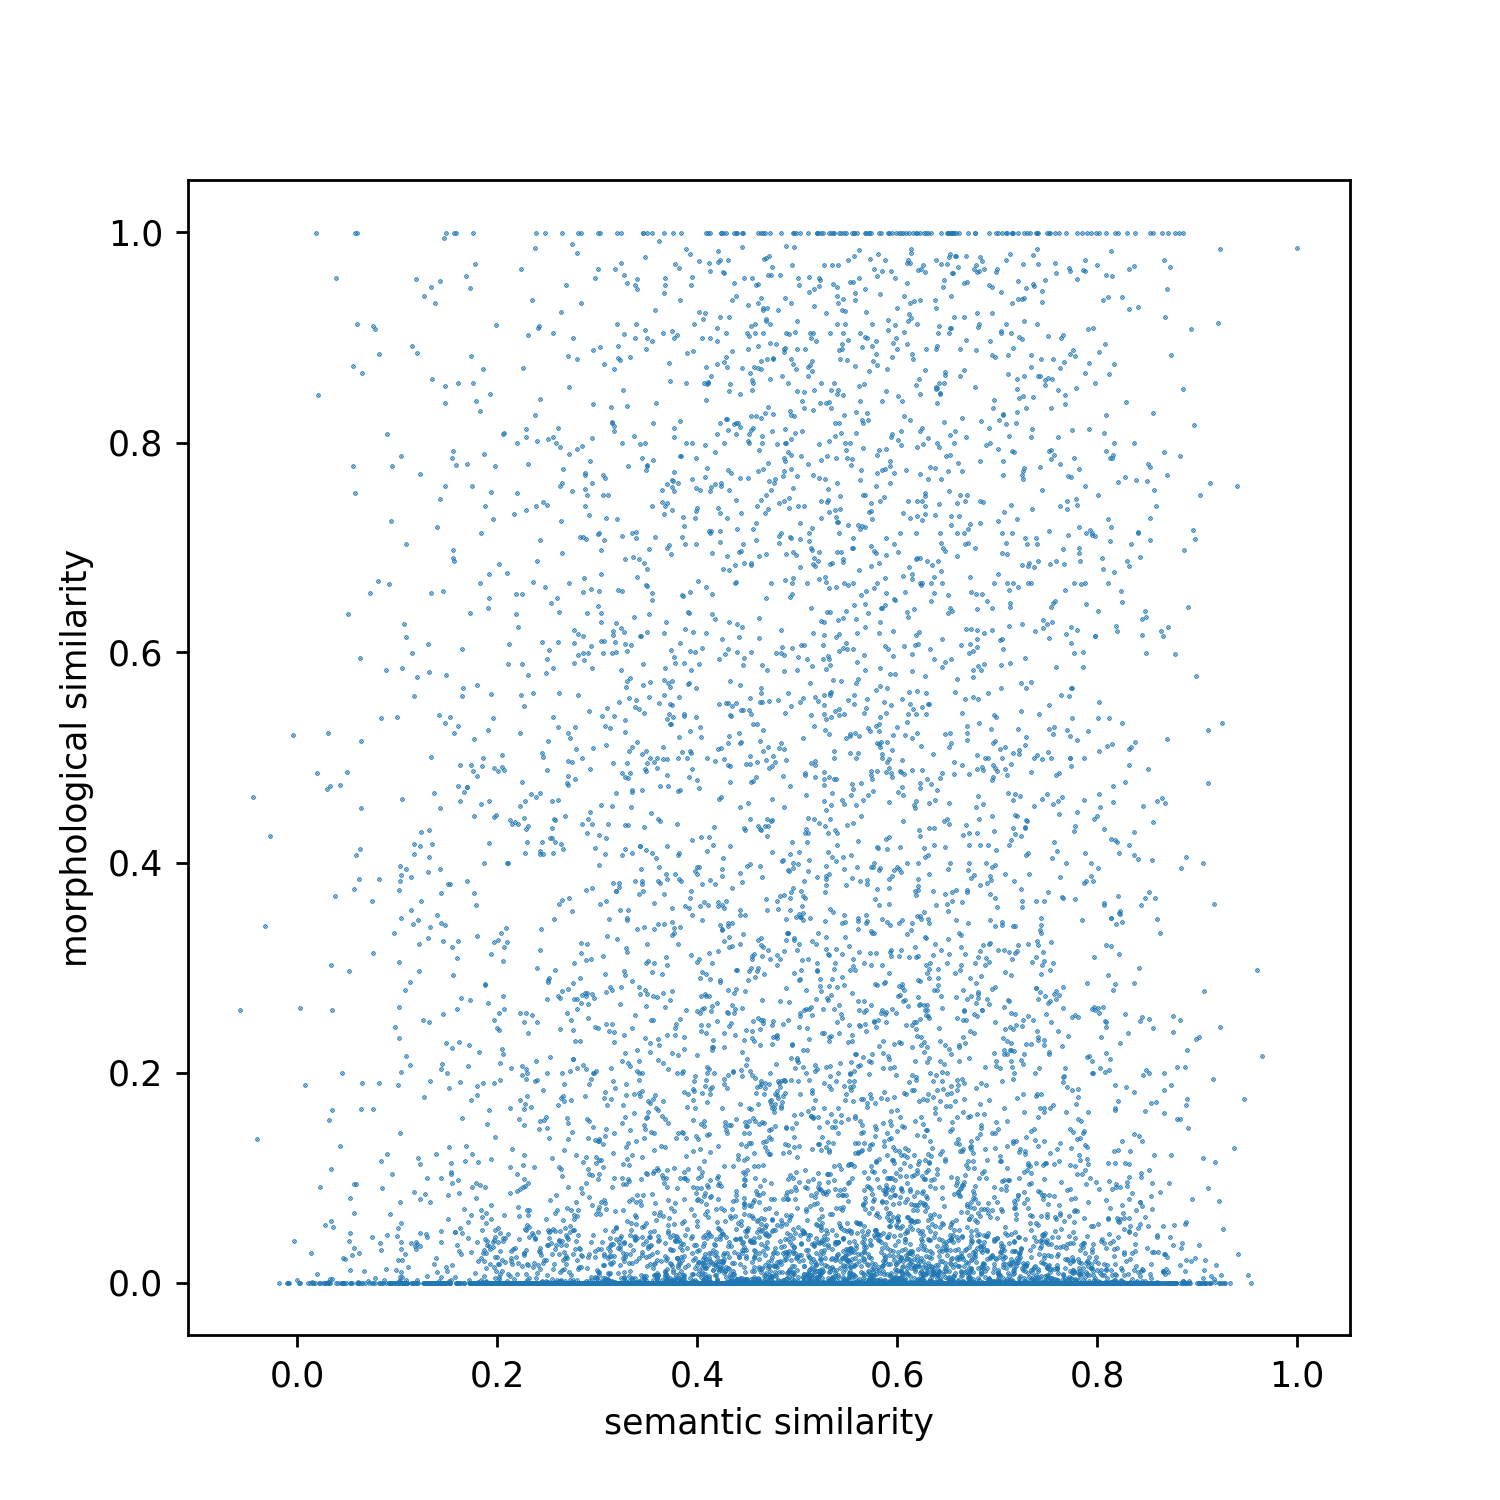

In [33]:
fig = plt.figure(figsize=(6,6))
plt.scatter(distComparison[:,0], distComparison[:,1], s=0.1)
plt.xlabel("semantic similarity")
plt.ylabel("morphological similarity")
plt.show()

In [34]:
scipy.stats.pearsonr(distComparison[:,0], distComparison[:,1])

(0.004020015068451112, 0.6877187062325897)

In [35]:
scipy.stats.spearmanr(distComparison)

SpearmanrResult(correlation=-0.004055407072106788, pvalue=0.6851161336729014)

In [51]:
nSamples = 10000
minDim = 5
maxDim = 20
correlations = np.zeros((len(range(minDim, maxDim+1)), 3))
for nDimension in range(minDim, maxDim+1):
    print(nDimension)
    sigmaBrown_reduced = np.zeros(sigmaBrown_flat.shape)
    sigmaBrown_reduced[:nDimension] = sigmaBrown_flat[:nDimension]
    brown_count_reduced = uBrown * sigmaBrown_reduced @ vtBrown
    distComparison = np.zeros((nSamples, 2))
    for i in range(nSamples):
        wi1, wi2 = random.randint(len(brown_wordlist), size=2)
        distComparison[i,0] = cosine_sim(brown_count_reduced[wi1,:], brown_count_reduced[wi2,:])
        distComparison[i,1] = posDists[wi1,:] @ posDists[wi2,:]
        spCor = scipy.stats.spearmanr(distComparison)
        cc = spCor.correlation
        pv = spCor.pvalue
        correlations[nDimension-minDim,:] = nDimension, cc, pv

5
6
7


/home/gjaeger/anaconda3/envs/vss/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


8
9
10
11
12
13
14
15
16
17
18
19
20


<IPython.core.display.Javascript object>


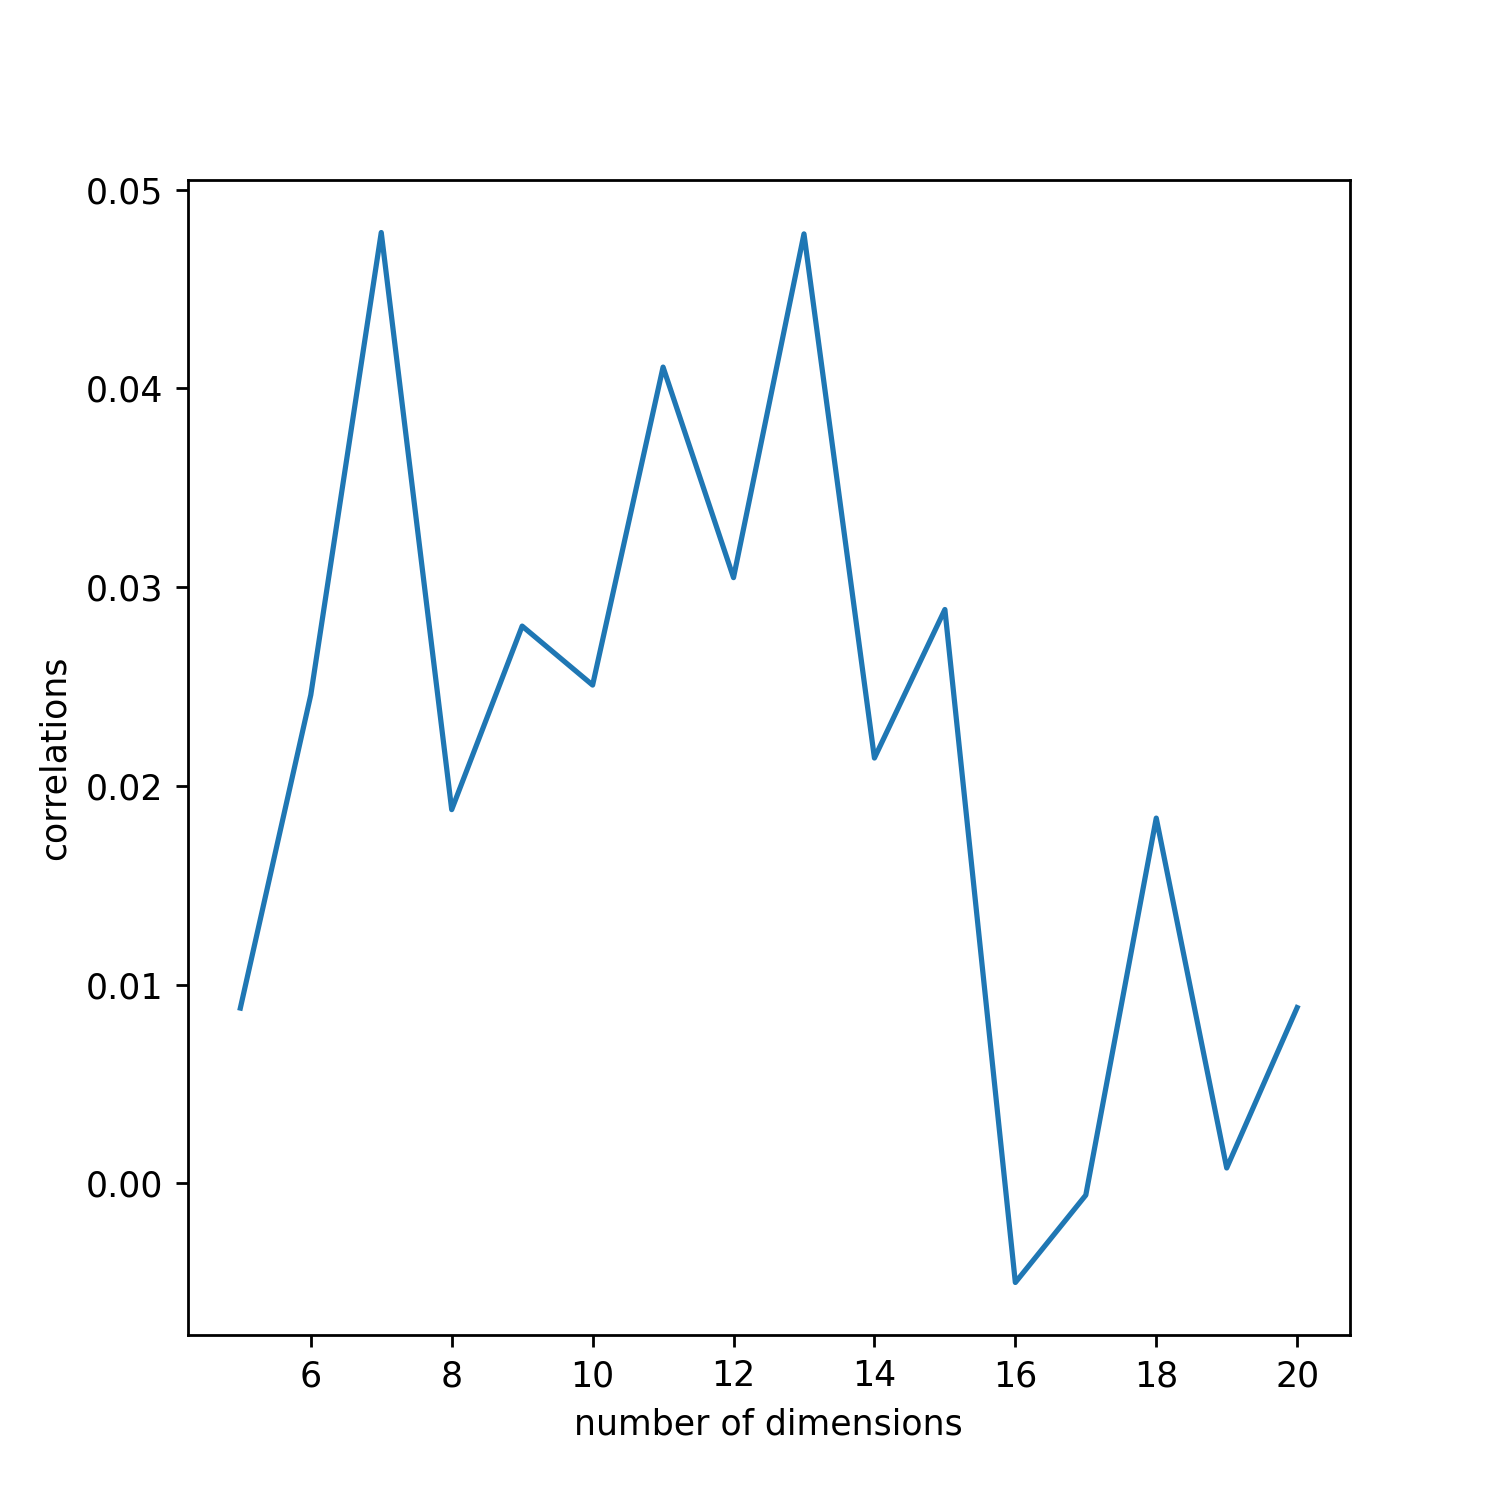

In [52]:
fig = plt.figure(figsize=(6,6))
plt.plot(correlations[:,0], correlations[:,1])
plt.xlabel("number of dimensions")
plt.ylabel("correlations")
plt.show()